In [ ]:
# detrend_smemp_properties.ipynb
# Script to compare the properties derived using Specmath-emp on APF spectra to the properties reported in the Yee et al. 
# 2017 library and calculate the detrending. 
# Last modified 7/2/21 by Anna Zuckerman 
#
# Input: specmatch_results.csv, generated by running smemp_multifile.ipynb on the APF calibration target stars.
# Output:  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from scipy.optimize import curve_fit

In [23]:
# find HIP names of each star in order to compare the same stars
def get_HIPname(name):
    if name.startswith('HIP'):
            HIP_name = name
    else:      
        try:
            result_table = Simbad.query_objectids(name)
            alt_names = result_table.to_pandas()
            alt_names = alt_names.iloc[:,0].str.decode('utf-8') #gets rid of weird formatting
            HIP_name = alt_names[alt_names.str.contains("HIP")]
            if len(HIP_name) == 0:
                HIP_name = 'None'
                print(name + ' has no HIP name in SIMBAD') #this should never occur since only using stars with HIP names for finding overlap between apf and Yee
            elif len(HIP_name) == 1:
                HIP_name = str(HIP_name.iloc[0]) # makes it a string instead of dataframe with one cell  
            else:
                print('more than one HIP name found for ' + name)
        except AttributeError:
            HIP_name = 'None'
            print(name + ': SIMBAD search error (likely \'No known catalog could be found\' or \'this identifier has an incorrect format for catalog\'') # should not happen
    return HIP_name


In [24]:
# read in files BL_APF_DAP/SM_steller_properties/specmatch_results_full.csv
apf_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_full.csv') # SM-Emp values derived from APF spectra
apf_data_detrended = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_detrended.csv') # SM-Emp values derived from APF spectra, detrended in run_smemp_apf.ipynb
apf_data_SM_detrended = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_calib.csv') # SM-Emp values derived from APF spectra, detrended in SM-Emp detrend() itself
hires_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/lincomb_results_detrend.csv') # SM-Emp values derived from HIRES spectra (detrended)
yee_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/yee_library_full.csv') # library values


# process names in file so be searchable by Simbad (move this logic to inside get_HIPname loop to speed up!)
for row in range(len(apf_data)):
    name = apf_data.iloc[row,0]
    if name[0].isdigit():
        apf_data.iloc[row,0] = 'HD' + name
    elif name.startswith('K0'):
        apf_data.iloc[row,0] = 'KOI-' + name[1:]
    elif name.startswith('EPIC-'):
        apf_data.iloc[row,0] = 'EPIC' + name[5:]

# process names in file so be searchable by Simbad (move this logic to inside get_HIPname loop to speed up!)
for row in range(len(apf_data_detrended)):
    name = apf_data_detrended.iloc[row,0]
    if name[0].isdigit():
        apf_data_detrended.iloc[row,0] = 'HD' + name
    elif name.startswith('K0'):
        apf_data_detrended.iloc[row,0] = 'KOI-' + name[1:]
    elif name.startswith('EPIC-'):
        apf_data_detrended.iloc[row,0] = 'EPIC' + name[5:]       
        
# sort by HIP name of stars for easy comparison
apf_HIP = apf_data
for row in range(len(apf_data)):
    apf_HIP.iloc[row,0] = get_HIPname(apf_data.iloc[row,0]).replace(' ','')
apf_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_sorted = apf_HIP.sort_values(by=['HIP_name'])

yee_HIP = yee_data
drop_rows = []
for row in range(len(yee_data)):
    yee_HIP.iloc[row,0] = get_HIPname(yee_data.iloc[row,0]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(yee_HIP.iloc[row,0]).any()):
        drop_rows = drop_rows + [row]
yee_HIP = yee_HIP.drop(drop_rows)
yee_HIP.rename(columns = {'Name':'HIP_name'}, inplace = True)
yee_sorted = yee_HIP.sort_values(by=['HIP_name'])

hires_HIP = hires_data
drop_rows = []
for row in range(len(hires_data)):
    hires_HIP.iloc[row,4] = get_HIPname(hires_data.iloc[row,4]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(hires_HIP.iloc[row,4]).any()):
        drop_rows = drop_rows + [row]
hires_HIP = hires_HIP.drop(drop_rows)
hires_HIP.rename(columns = {'source_name':'HIP_name'}, inplace = True)
hires_sorted = hires_HIP.sort_values(by=['HIP_name'])

apf_det_HIP = apf_data_detrended
for row in range(len(apf_data_detrended)):
    apf_det_HIP.iloc[row,0] = get_HIPname(apf_data_detrended.iloc[row,0]).replace(' ','')
apf_det_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_det_sorted = apf_det_HIP.sort_values(by=['HIP_name'])

apf_det_SM_HIP = apf_data_SM_detrended
for row in range(len(apf_data_SM_detrended)):
    apf_det_SM_HIP.iloc[row,0] = get_HIPname(apf_data_SM_detrended.iloc[row,0]).replace(' ','')
apf_det_SM_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_det_SM_sorted = apf_det_SM_HIP.sort_values(by=['HIP_name'])

/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : HD 124257A
  (error.line, error.msg))


HD 124257A  : SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
HD 3684      has no HIP name in SIMBAD
KOI-1925     has no HIP name in SIMBAD
KOI-1612     has no HIP name in SIMBAD
KIC 10018963 has no HIP name in SIMBAD
KIC 10355856 has no HIP name in SIMBAD
KIC 10516096 has no HIP name in SIMBAD
KIC 10644253 has no HIP name in SIMBAD
KIC 10709834 has no HIP name in SIMBAD
KIC 11026764 has no HIP name in SIMBAD
KIC 11137075 has no HIP name in SIMBAD
KIC 11244118 has no HIP name in SIMBAD
KIC 11414712 has no HIP name in SIMBAD
KIC 11717120 has no HIP name in SIMBAD
KIC 12009504 has no HIP name in SIMBAD
KIC 1435467  has no HIP name in SIMBAD
KIC 3427720  has no HIP name in SIMBAD
KIC 3656476  has no HIP name in SIMBAD
KIC 5021689  has no HIP name in SIMBAD
KIC 5184732  has no HIP name in SIMBAD
KIC 5596656  has no HIP name in SIMBAD
KIC 5773345  has no HIP name in SIMBAD
KIC 5955122  has no HIP name in SIMBAD
KIC 61160

/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : HD 124257A
  (error.line, error.msg))


HD 3684 has no HIP name in SIMBAD
KIC9955598 has no HIP name in SIMBAD
KIC10963065 has no HIP name in SIMBAD
KIC10018963 has no HIP name in SIMBAD
KIC10355856 has no HIP name in SIMBAD
KIC10516096 has no HIP name in SIMBAD
KIC10644253 has no HIP name in SIMBAD
KIC10709834 has no HIP name in SIMBAD
KIC11026764 has no HIP name in SIMBAD
KIC11137075 has no HIP name in SIMBAD
KIC11244118 has no HIP name in SIMBAD
KIC11414712 has no HIP name in SIMBAD
KIC11717120 has no HIP name in SIMBAD
KIC12009504 has no HIP name in SIMBAD
KIC1435467 has no HIP name in SIMBAD
KIC3427720 has no HIP name in SIMBAD
KIC3656476 has no HIP name in SIMBAD
KIC5021689 has no HIP name in SIMBAD
KIC5184732 has no HIP name in SIMBAD
KIC5596656 has no HIP name in SIMBAD
KIC5773345 has no HIP name in SIMBAD
KIC5955122 has no HIP name in SIMBAD
KIC6116048 has no HIP name in SIMBAD
KIC6442183 has no HIP name in SIMBAD
KIC6603624 has no HIP name in SIMBAD
KIC6933899 has no HIP name in SIMBAD
KIC7206837 has no HIP name in

/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): '195564': No known catalog could be found
  (error.line, error.msg))
/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): '200964': No known catalog could be found
  (error.line, error.msg))
/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): '201092': No known catalog could be found
  (error.line, error.msg))
/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute

195564: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
200964: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
201092: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
209290: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
217107: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
222368: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
16160: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
1326: SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format 

/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): '161797': No known catalog could be found
  (error.line, error.msg))
/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): '168443': No known catalog could be found
  (error.line, error.msg))
/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): '11964': No known catalog could be found
  (error.line, error.msg))
/home/azuckerman/.local/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute 

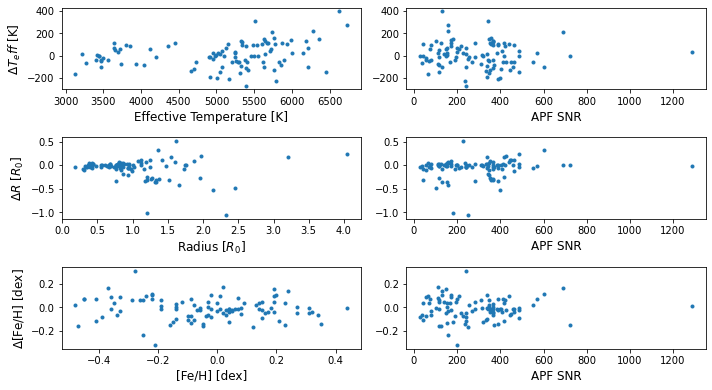

In [30]:
# plot certain properties to compare

SNR_results = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SNR_results.csv')
SNR_results_sorted = SNR_results.sort_values(by=['HIP_NAME'])
apf_SNR = SNR_results_sorted['SNR']
 
apf_Teff = apf_sorted.iloc[:,1].to_numpy() 
yee_Teff = yee_sorted.iloc[:,1].to_numpy()
hires_Teff = hires_sorted.iloc[:,86].to_numpy()
apf_det_Teff = apf_det_sorted.iloc[:,1].to_numpy() 
apf_det_SM_Teff = apf_det_SM_sorted['Teff_detrended'].to_numpy() 
apf_R = apf_sorted.iloc[:,3].to_numpy()
yee_R = yee_sorted.iloc[:,3].to_numpy()
hires_R = hires_sorted.iloc[:,89].to_numpy()
apf_det_R = apf_det_sorted.iloc[:,3].to_numpy()
apf_det_SM_R = apf_det_SM_sorted['radius_detrended'].to_numpy() 
apf_feh = apf_sorted.iloc[:,7].to_numpy()
yee_feh = yee_sorted.iloc[:,7].to_numpy()
hires_feh = hires_sorted.iloc[:,95].to_numpy()
apf_det_feh = apf_det_sorted.iloc[:,7].to_numpy()
apf_det_SM_feh = apf_det_SM_sorted['feh_detrended'].to_numpy() 
apf_logg = apf_sorted.iloc[:,5].to_numpy()
yee_logg = yee_sorted.iloc[:,5].to_numpy()
#hires_logg = hires_sorted.iloc[:,_].to_numpy()
#apf_det_logg = apf_det_sorted.iloc[:,_].to_numpy()
apf_mass = apf_sorted.iloc[:,9].to_numpy()
yee_mass = yee_sorted.iloc[:,9].to_numpy()
#hires_mass = hires_sorted.iloc[:,_].to_numpy()
#apf_det_mass = apf_det_sorted.iloc[:,_].to_numpy()
apf_age = apf_sorted.iloc[:,11].to_numpy()
yee_age = yee_sorted.iloc[:,11].to_numpy()
#hires_age = hires_sorted.iloc[:,_].to_numpy()
#apf_det_age = apf_det_sorted.iloc[:,_].to_numpy()

# remove  38th star (lowest SNR, outlier in being very far from Yee values)
# [NO LONGER RELEVENT]
#apf_Teff = np.append(apf_Teff[0:38],apf_Teff[39:])
#yee_Teff = np.append(yee_Teff[0:38],yee_Teff[39:])
#apf_R = np.append(apf_R[0:38],apf_R[39:])
#yee_R = np.append(yee_R[0:38],yee_R[39:])
#apf_feh = np.append(apf_feh[0:38],apf_feh[39:])
#yee_feh = np.append(yee_feh[0:38],yee_feh[39:])
#apf_SNR = np.append(apf_SNR[0:38],apf_SNR[39:])

# plot difference between APF Specmatch and Yee properties, vs Yee Properties
fig, axs = plt.subplots(3, 2, figsize = (10,6)) 
delta_Teff = yee_Teff - apf_Teff 
axs[0,0].plot(yee_Teff,delta_Teff,'.') 
axs[0,0].set_xlabel('Effective Temperature [K]',fontsize = 12)
axs[0,0].set_ylabel('$\Delta T_eff$ [K]',fontsize = 12)
delta_R = yee_R-apf_R
delta_R_R = (yee_R-apf_R)/apf_R # ORIGINALLY YEE_R in demoninator 
axs[1,0].plot(yee_R, delta_R,'.')
axs[1,0].set_xlabel('Radius [$R_0$]',fontsize = 12)
axs[1,0].set_ylabel('$\Delta R$ [$R_0$]',fontsize = 12)
delta_feh = yee_feh-apf_feh
axs[2,0].plot(yee_feh, delta_feh,'.')
axs[2,0].set_xlabel('[Fe/H] [dex]',fontsize = 12)
axs[2,0].set_ylabel('$\Delta$[Fe/H] [dex]',fontsize = 12)
#fig.suptitle('APF Specmatch-emp derived properties vs properties reported by Yee et al.')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison.png')

delta_logg = yee_logg-apf_logg
delta_mass = yee_mass-apf_mass
delta_age = yee_age-apf_age

# plot difference between APF Specmatch and Yee properties, vs APF SNR
#fig, axs = plt.subplots(3, 1, figsize = (6,6)) 
axs[0,1].plot(apf_SNR, delta_Teff,'.') #Is this right to use Yee as the x-axis, 'correct' T value?
axs[0,1].set_xlabel('APF SNR',fontsize = 12)
#axs[0,1].set_ylabel('$\Delta T_eff$ [K]',fontsize = 14)
axs[1,1].plot(apf_SNR, delta_R,'.') # why normalize to R?
axs[1,1].set_xlabel('APF SNR',fontsize = 12)
#axs[1,1].set_ylabel('$\Delta R/ R$ [$R_0$]',fontsize = 14)
axs[2,1].plot(apf_SNR, delta_feh,'.')
axs[2,1].set_xlabel('APF SNR',fontsize = 12)
#axs[2,1].set_ylabel('$\Delta$[Fe/H] [dex]',fontsize = 14)
#fig.suptitle('Difference APF to catalog values vs SNR of APF data')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison_SNR.png')

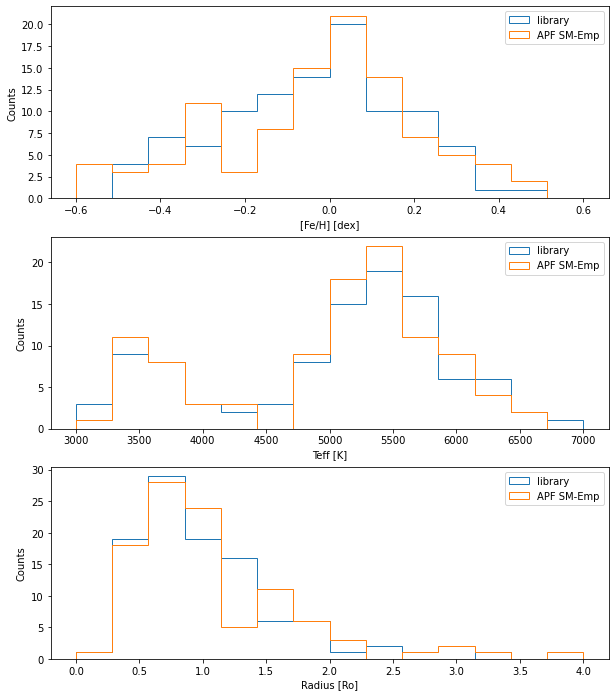

In [384]:
# histogram the parameters

plt.figure(figsize = [10,12])
plt.subplot(311)
plt.hist(yee_feh, histtype = 'step', label = 'library', bins = np.linspace(-0.6,0.6,15))
plt.hist(apf_feh, histtype = 'step', label = 'APF SM-Emp',  bins = np.linspace(-0.6,0.6,15))
plt.ylabel('Counts')
plt.xlabel('[Fe/H] [dex]')
plt.legend()
plt.subplot(312)
plt.hist(yee_Teff, histtype = 'step', label = 'library', bins = np.linspace(3000,7000,15))
plt.hist(apf_Teff, histtype = 'step', label = 'APF SM-Emp', bins = np.linspace(3000,7000,15))
plt.ylabel('Counts')
plt.xlabel('Teff [K]')
plt.legend()
plt.subplot(313)
plt.hist(yee_R, histtype = 'step', label = 'library', bins = np.linspace(0,4,15))
plt.hist(apf_R, histtype = 'step', label = 'APF SM-Emp',bins = np.linspace(0,4,15))
plt.ylabel('Counts')
plt.xlabel('Radius [Ro]')
plt.legend()
#plt.suptitle('Library Values', y = 0.95)



Text(0.5, 0, 'Hires derived [Fe/H] [dex]')

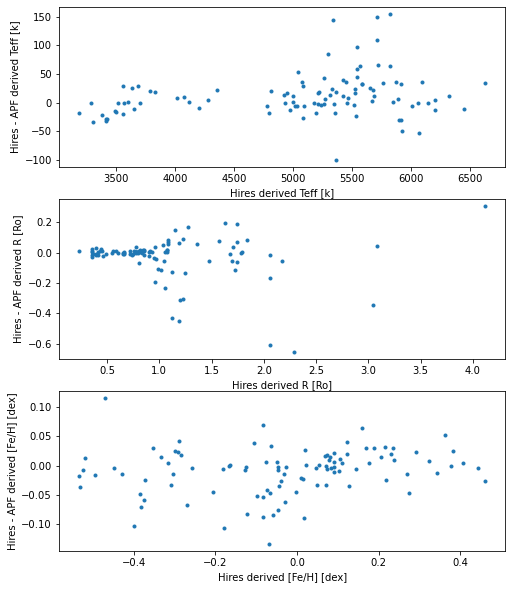

In [330]:
# compare the apf derived values and the Hires derived values

plt.figure(figsize = [8,10])
#plt.plot(hires_Teff, apf_Teff, '.')
plt.subplot(311)
plt.plot(hires_Teff, hires_Teff - apf_Teff, '.')
plt.ylabel('Hires - APF derived Teff [k]')
plt.xlabel('Hires derived Teff [k]')

plt.subplot(312)
#plt.plot(hires_R, apf_R, '.')
plt.plot(hires_R, hires_R - apf_R, '.')
plt.ylabel('Hires - APF derived R [Ro]')
plt.xlabel('Hires derived R [Ro]')

plt.subplot(313)
#plt.plot(hires_Teff, apf_Teff, '.')
plt.plot(hires_feh, hires_feh - apf_feh, '.')
plt.ylabel('Hires - APF derived [Fe/H] [dex]')
plt.xlabel('Hires derived [Fe/H] [dex]')


In [9]:
def fit_trend(apf_values, deltas, order, region_set, i, j, label = 'Values [?]', make_plots = 0):
    red_chi_sq = 0       
    #resids_all_regions = np.array([])
    SE_all_regions = np.array([])
    if make_plots: plt.subplot(4,2,j)
    j += 1 # j = which fit (ie. which set of poly order and number of regions)
    trends = []
    polys = []
    for region in region_set:
        poly  = np.polyfit(apf_values[region], deltas[region], order, full = False) # numpy arr of coeffs
        trend = np.poly1d(poly) 
        polys += [poly]
        trends += [trend]
        #print(residuals)
        resids = (deltas[region] - trend(apf_values[region]))
        chi_sq = np.sum((resids**2)/trend(apf_values[region]))  # Q: should divide by trend value?? Or len of region?
        dof = len(deltas) -  ((order + 1) + len(region_set)) # number of osbervations minus number fit parameters NOTE: this term is same for all regions
        red_chi_sq += chi_sq / dof  # But doesn't dividing by DOF mean lower chi^2 = better if more dof DOF??
        SE = resids**2
        #plt.subplot(1,2,j)
        if make_plots:
            plt.plot(apf_values[region], deltas[region],'.')
            plt.plot(np.sort(apf_values[region]), trend(np.sort(apf_values[region])), label = 'Fit: ' + str(trend) )#+ '\n' + 'Reduced chi square: ' + str(np.round(red_chi_sq,3)))
            #plt.text()
            plt.xlabel('Derived ' + label); plt.ylabel('Delta ' + label), plt.legend()
        SE_all_regions = np.hstack([SE_all_regions, SE])
    #resids_all_regions = np.hstack([resids_all_regions, resids])
    RMSE[order, i] = np.sqrt(np.mean(SE_all_regions))
    red_chi_sq_arr[order, i] = red_chi_sq 
    i += 1 # increment which region set we are looking at (gets reset to 0 outside of this function for each order)

    return trends, polys, RMSE, red_chi_sq_arr, i, j
 

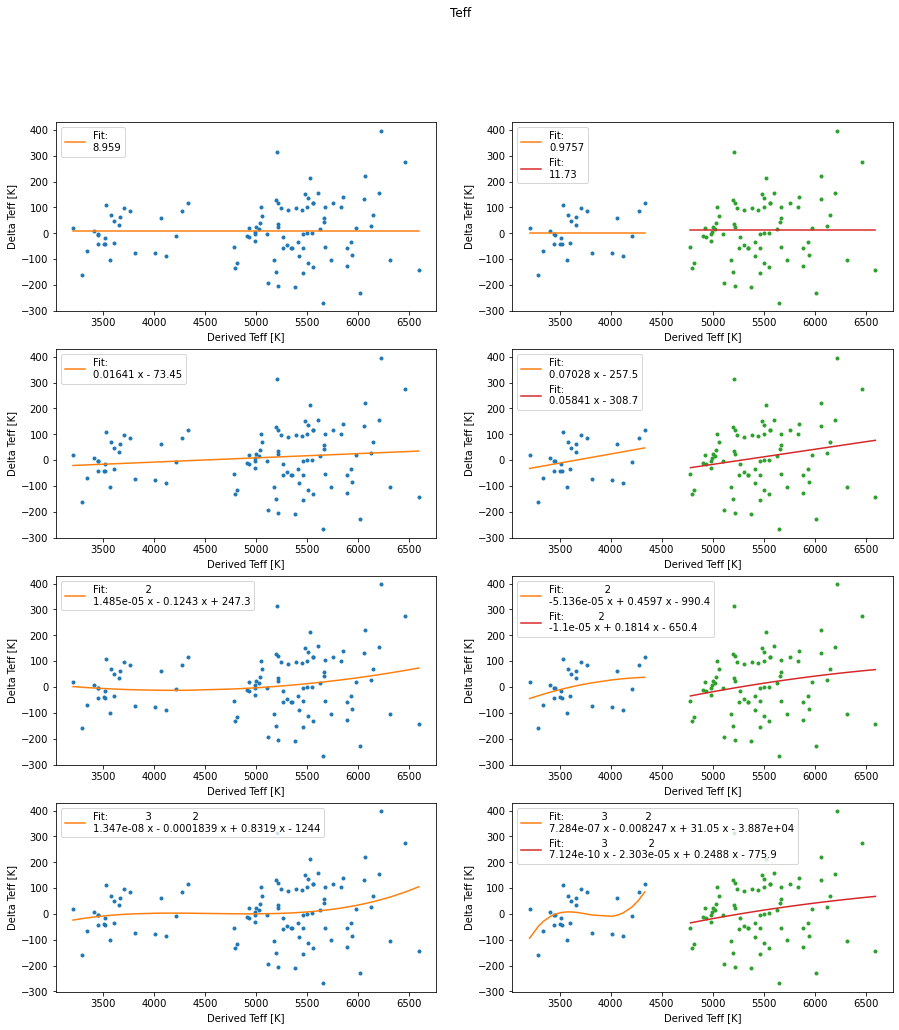

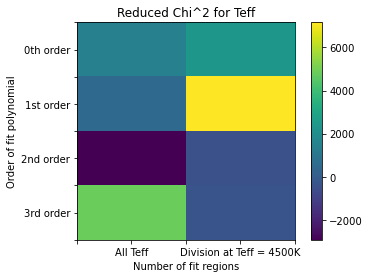

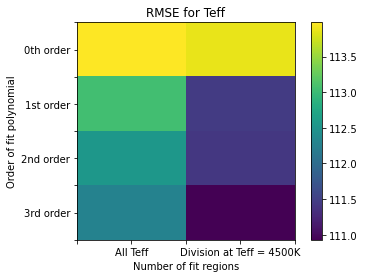

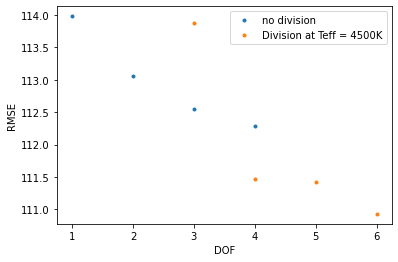

In [332]:
# choosing the right fit function and regions to fit for Teff

delta_Teff_sorted = delta_Teff[np.argsort(apf_Teff)]
apf_Teff_sprted = np.sort(apf_Teff)

# Teff
#Teff_regions_list = [[slice(0,apf_Teff[-1])], [slice(0,), slice(4501,apf_Teff[-1])]]
Teff_regions_list = [[(apf_Teff > 0)], [(apf_Teff <= 4500), (apf_Teff > 4500)]]
red_chi_sq_arr = np.zeros([4,len(Teff_regions_list)])
RMSE = np.zeros([4,len(Teff_regions_list)])
plt.figure(figsize = [15,16])
j = 1
for order in [0,1,2,3]:
    i = 0
    for region_set in Teff_regions_list:
        trend, poly,  RMSE, red_chi_sq_arr, i, j= fit_trend(apf_Teff, delta_Teff, order, region_set, i, j, 'Teff [K]', 1)
        plt.suptitle('Teff')
        
plt.figure()
ax = plt.gca()
plt.imshow(red_chi_sq_arr, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All Teff'; labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('Reduced Chi^2 for Teff')
plt.colorbar()

plt.figure()
ax = plt.gca()
plt.imshow(RMSE, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All Teff'; labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('RMSE for Teff')
plt.colorbar()

plt.figure()
plt.plot(np.array([1,2,3,4]),RMSE[:,0], '.', label = 'no division')
plt.plot(np.array([3,4,5,6]),RMSE[:,1], '.', label = 'Division at Teff = 4500K')
plt.xlabel('DOF'); plt.ylabel('RMSE'); plt.legend()

#plt.xticklabel('')

0 1
1 2
0 3
1 4
0 5
1 6
0 7
1 8


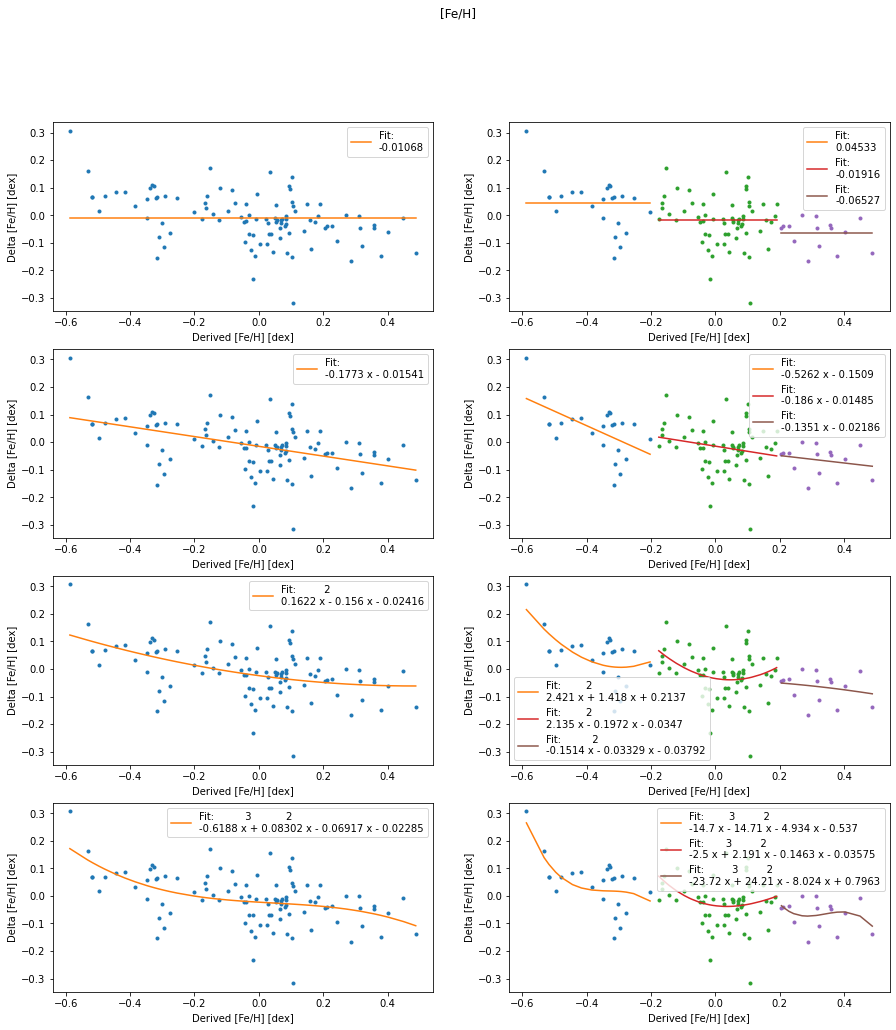

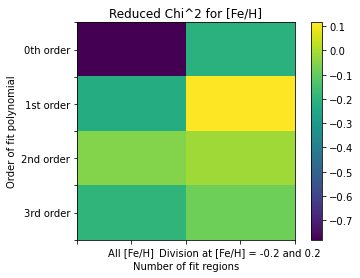

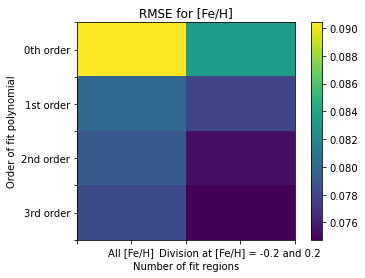

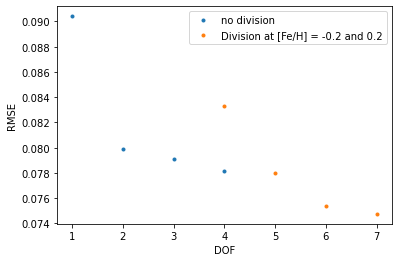

In [333]:
# choosing the right fit function and regions to fit for [Fe/H]

delta_feh_sorted = delta_feh[np.argsort(apf_feh)]
apf_feh_sprted = np.sort(apf_feh)

# Teff
#Teff_regions_list = [[slice(0,apf_Teff[-1])], [slice(0,), slice(4501,apf_Teff[-1])]]
feh_regions_list = [[(np.invert(np.isnan(apf_feh)))], [(apf_feh <= -0.2), (apf_feh > -0.2)*(apf_feh <= 0.2), (apf_feh > 0.2)]]
red_chi_sq_arr = np.zeros([4,len(feh_regions_list)])
RMSE = np.zeros([4,len(Teff_regions_list)])
plt.figure(figsize = [15,16])
j = 1
for order in [0,1,2,3]:
    i = 0
    for region_set in feh_regions_list: 
        print(i,j)
        trend, poly,  RMSE, red_chi_sq_arr, i, j= fit_trend(apf_feh, delta_feh, order, region_set, i, j, '[Fe/H] [dex]', 1)
        plt.suptitle('[Fe/H]') 

plt.figure()
ax = plt.gca()
plt.imshow(red_chi_sq_arr, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All [Fe/H]'; labels[3] = 'Division at [Fe/H] = -0.2 and 0.2'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('Reduced Chi^2 for [Fe/H]')
plt.colorbar()

plt.figure()
ax = plt.gca()
plt.imshow(RMSE, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All [Fe/H]'; labels[3] = 'Division at [Fe/H] = -0.2 and 0.2'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('RMSE for [Fe/H]')
plt.colorbar()
#plt.xticklabel('')

plt.figure()
plt.plot(np.array([1,2,3,4]),RMSE[:,0], '.', label = 'no division')
plt.plot(np.array([4,5,6,7]),RMSE[:,1], '.', label = 'Division at [Fe/H] = -0.2 and 0.2')
plt.xlabel('DOF'); plt.ylabel('RMSE'); plt.legend()

poly order: 0
poly order: 1
poly order: 2
poly order: 3


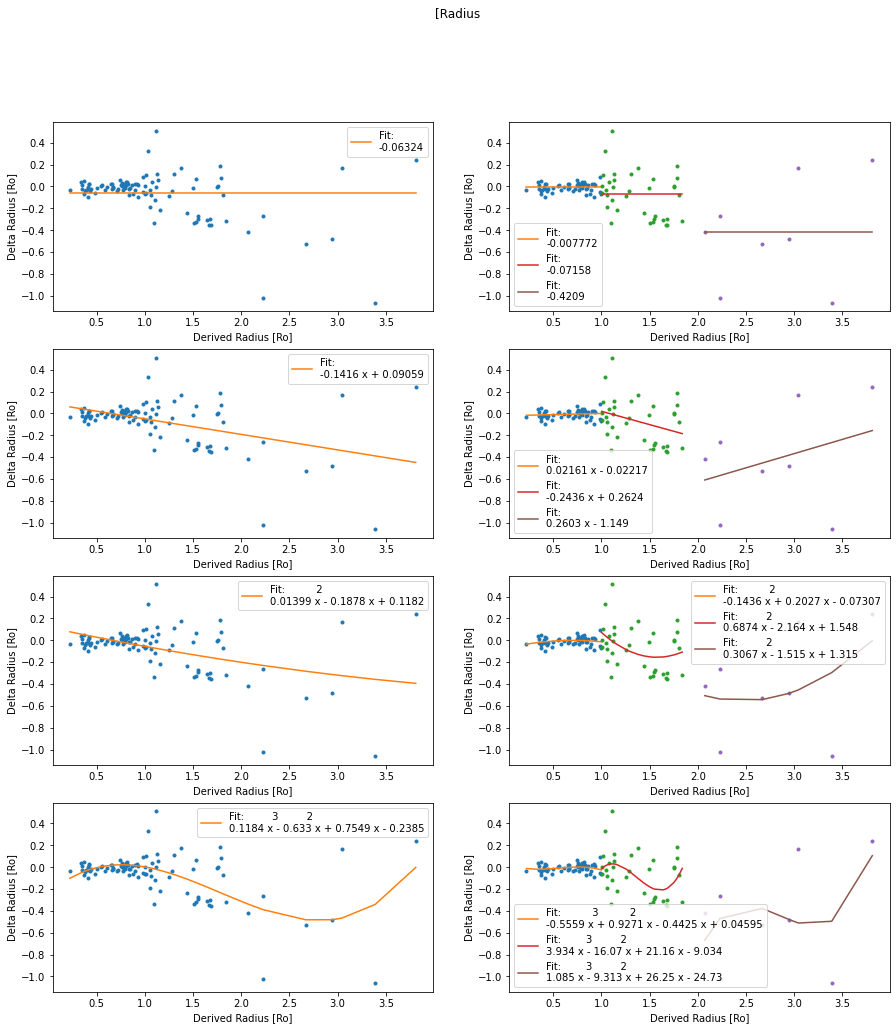

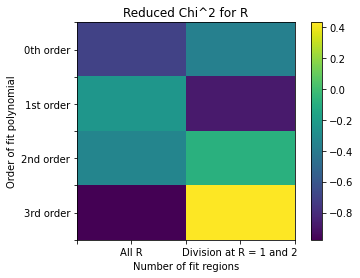

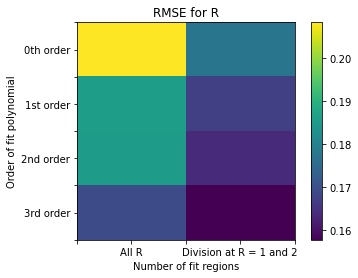

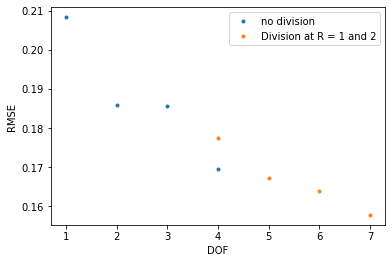

In [334]:
# choosing the right fit function and regions to fit for R

delta_R_sorted = delta_R[np.argsort(apf_R)]
apf_R_sorted = np.sort(apf_R)

# Teff
#Teff_regions_list = [[slice(0,apf_Teff[-1])], [slice(0,), slice(4501,apf_Teff[-1])]]
R_regions_list = [[(apf_R > 0)], [(apf_R <= 1.0), (apf_R > 1.0)*(apf_R <= 2.0), (apf_R > 2.0)]]
red_chi_sq_arr = np.zeros([4,len(R_regions_list)])
RMSE = np.zeros([4,len(R_regions_list)])
plt.figure(figsize = [15,16])
j = 1
for order in [0,1,2,3]:
    print('poly order: ' + str(order))
    i = 0
    for region_set in R_regions_list: 
        trend, poly, RMSE, red_chi_sq_arr, i, j= fit_trend(apf_R, delta_R, order, region_set, i, j, 'Radius [Ro]', 1)
        plt.suptitle('[Radius') 
#        print('   regions: ' + str(len(region_set)))
#       red_chi_sq = 0       
#      plt.subplot(4,2,j)
#     plt.xscale('log')
#        j += 1
#        SE_all_regions = np.array([])
#        for region in region_set:
#            poly  = np.polyfit(apf_R[region], delta_R_R[region], order, full = False)
#            trend = np.poly1d(poly)
#            #print(residuals)
#            resids = (delta_R_R[region] - trend(apf_R[region]))
#            chi_sq = np.sum((resids**2)/trend(apf_R[region]))  # Q: should divide by trend value?? Or len of region?
#            dof = len(delta_R_R) -  ((order + 1) + len(region_set)) # number of osbervations minus number fit parameters NOTE: this term is same for all regions
#            red_chi_sq += chi_sq / dof  # But doesn't dividing by DOF mean lower chi^2 = better if more dof DOF??
#            SE = resids**2 
#            #print(np.sqrt(np.mean(SE)))
#            #chi_sq = np.sum((delta_R[region] - trend(apf_R[region]))**2) # Q: should divide by trend value?? Or len of region?
#            #red_chi_sq += chi_sq / (order + 1)
#            #plt.subplot(1,2,j)
#            plt.plot(apf_R[region], delta_R_R[region],'.')
#            plt.plot(np.sort(apf_R[region]), trend(np.sort(apf_R[region])), label = 'Fit: ' + str(trend) + '\n' + 'Reduced chi square: ' + str(np.round(red_chi_sq,3)))
#            #plt.text()
#            plt.xlabel('Derived R [Ro]'); plt.ylabel('Delta R/R [Ro]'), plt.legend()
#            SE_all_regions = np.hstack([SE_all_regions, SE])
#        #resids_all_regions = np.hstack([resids_all_regions, resids])
#        RMSE[order, i] = np.sqrt(np.mean(SE_all_regions))
#        print('   RMSE: ' + str(np.sqrt(np.mean(SE_all_regions))))
#        red_chi_sq_arr[order, i] = red_chi_sq
#        i += 1
#
#plt.suptitle('Radius') 


plt.figure()
ax = plt.gca()
plt.imshow(red_chi_sq_arr, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All R'; labels[3] = 'Division at R = 1 and 2'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('Reduced Chi^2 for R')
plt.colorbar()


plt.figure()
ax = plt.gca()
plt.imshow(RMSE, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All R'; labels[3] = 'Division at R = 1 and 2'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('RMSE for R')
plt.colorbar()
#plt.xticklabel('')

plt.figure()
plt.plot(np.array([1,2,3,4]),RMSE[:,0], '.', label = 'no division')
plt.plot(np.array([4,5,6,7]),RMSE[:,1], '.', label = 'Division at R = 1 and 2')
plt.xlabel('DOF'); plt.ylabel('RMSE'); plt.legend()

% decrease no detrend to constant offset: 6.996444140572646
% decrease constant offset to linear: 1.147332268312115
% decrease linear to quad: 0.9856484543515638


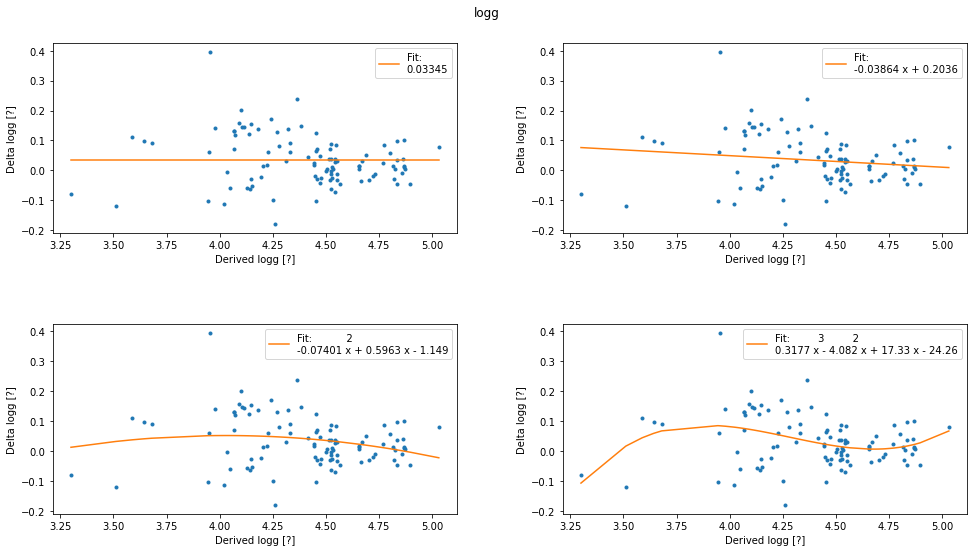

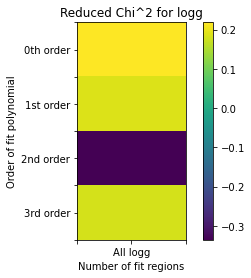

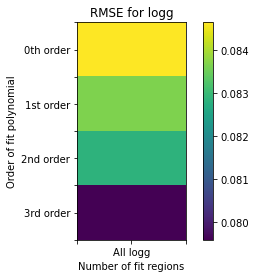

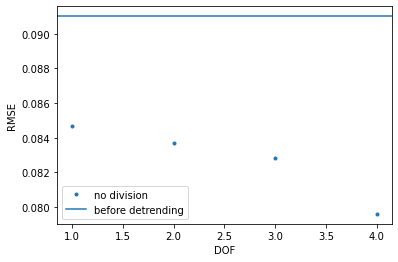

In [97]:
#choosing the right fit function and regions to fit for logg

delta_logg_sorted = delta_logg[np.argsort(apf_logg)]
apf_logg_sprted = np.sort(apf_logg)

# logg
#logg_regions_list = [[slice(0,apf_Teff[-1])], [slice(0,), slice(4501,apf_Teff[-1])]]
logg_regions_list = [[np.invert(np.isnan(apf_logg))]]
red_chi_sq_arr = np.zeros([4,len(logg_regions_list)])
RMSE_before_detrend = np.sqrt(np.mean(delta_logg**2))
RMSE = np.zeros([4,len(logg_regions_list)])
plt.figure(figsize = [15,16])
j = 1
for order in [0,1,2,3]:
    i = 0
    for region_set in logg_regions_list:
        trend, poly,  RMSE, red_chi_sq_arr, i, j= fit_trend(apf_logg, delta_logg, order, region_set, i, j, 'logg [?]', 1)
        plt.suptitle('logg')
plt.tight_layout(pad = 6)
        
plt.figure()
ax = plt.gca()
plt.imshow(red_chi_sq_arr, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All logg'; #labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('Reduced Chi^2 for logg')
plt.colorbar()

plt.figure()
ax = plt.gca()
plt.imshow(RMSE, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All logg'; #labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('RMSE for logg')
plt.colorbar()

plt.figure()
plt.plot(np.array([1,2,3,4]),RMSE[:,0], '.', label = 'no division')
plt.axhline(RMSE_before_detrend, label = 'before detrending')
#plt.plot(np.array([3,4,5,6]),RMSE[:,1], '.', label = 'Division at Teff = 4500K')
plt.xlabel('DOF'); plt.ylabel('RMSE'); plt.legend()

print('% decrease no detrend to constant offset: ' + str((RMSE_before_detrend - RMSE[0,0])*100/RMSE_before_detrend))
print('% decrease constant offset to linear: ' + str((RMSE[0,0]- RMSE[1,0])*100/RMSE[0,0]))
print('% decrease linear to quad: ' + str((RMSE[1,0] - RMSE[2,0])*100/RMSE[1,0]))
# so cutoff sohuld be like 5% decrease ---> constant offset for logg

#plt.xticklabel('')

% decrease no detrend to constant offset: 3.1192669759436313
% decrease constant offset to linear: 1.8746268862636102
% decrease linear to quad: 4.820581615601022


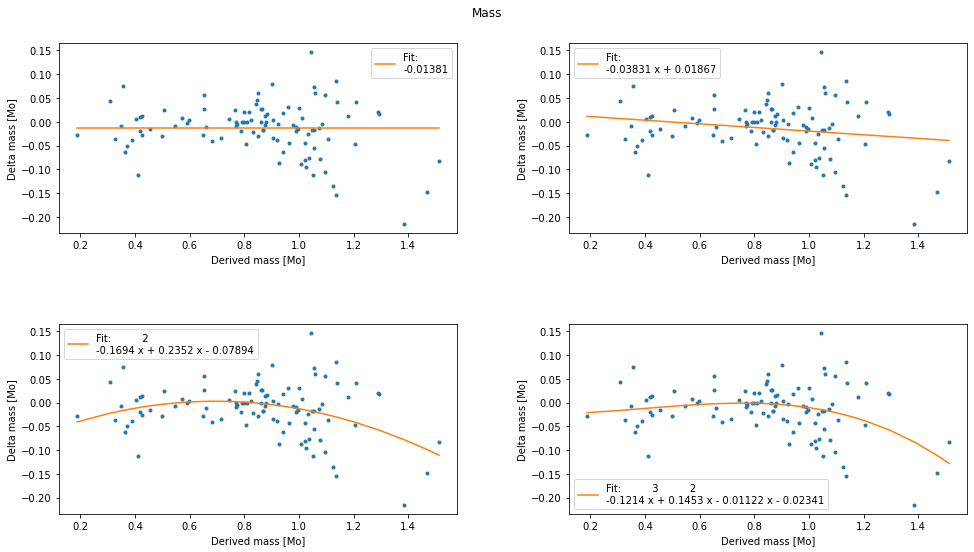

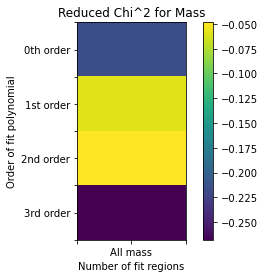

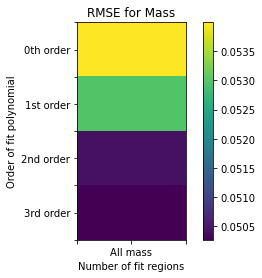

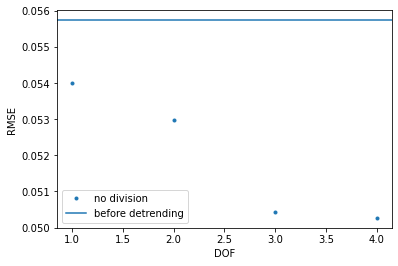

In [98]:
#choosing the right fit function and regions to fit for mass

delta_mass_sorted = delta_mass[np.argsort(apf_mass)]
apf_mass_sprted = np.sort(apf_mass)

# mass
#logg_regions_list = [[slice(0,apf_Teff[-1])], [slice(0,), slice(4501,apf_Teff[-1])]]
mass_regions_list = [[np.invert(np.isnan(apf_mass))]]
red_chi_sq_arr = np.zeros([4,len(mass_regions_list)])
RMSE_before_detrend = np.sqrt(np.mean(delta_mass**2))
RMSE = np.zeros([4,len(mass_regions_list)])
plt.figure(figsize = [15,16])
j = 1
for order in [0,1,2,3]:
    i = 0
    for region_set in mass_regions_list:
        trend, poly,  RMSE, red_chi_sq_arr, i, j= fit_trend(apf_mass, delta_mass, order, region_set, i, j, 'mass [Mo]', 1)
        plt.suptitle('Mass')
plt.tight_layout(pad = 6)  


plt.figure()
ax = plt.gca()
plt.imshow(red_chi_sq_arr, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All mass'; #labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('Reduced Chi^2 for Mass')
plt.colorbar()

plt.figure()
ax = plt.gca()
plt.imshow(RMSE, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All mass'; #labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('RMSE for Mass')
plt.colorbar()

plt.figure()
plt.plot(np.array([1,2,3,4]),RMSE[:,0], '.', label = 'no division')
plt.axhline(RMSE_before_detrend, label = 'before detrending')
#plt.plot(np.array([3,4,5,6]),RMSE[:,1], '.', label = 'Division at Teff = 4500K')
plt.xlabel('DOF'); plt.ylabel('RMSE'); plt.legend()

print('% decrease no detrend to constant offset: ' + str((RMSE_before_detrend - RMSE[0,0])*100/RMSE_before_detrend))
print('% decrease constant offset to linear: ' + str((RMSE[0,0]- RMSE[1,0])*100/RMSE[0,0]))
print('% decrease linear to quad: ' + str((RMSE[1,0] - RMSE[2,0])*100/RMSE[1,0]))
# so cutoff sohuld be like __% decrease --> using a constant offset because the linear trend is effected by outliers at large mass

#plt.xticklabel('')

% decrease no detrend to constant offset: 0.14453103179520585
% decrease constant offset to linear: 1.3651023500506856
% decrease linear to quad: 0.39008316806858445


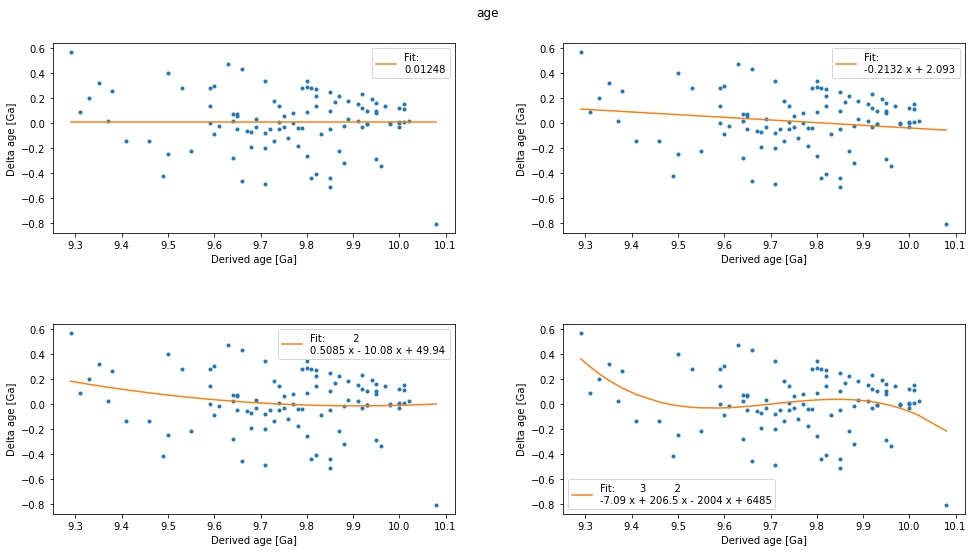

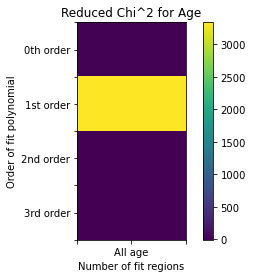

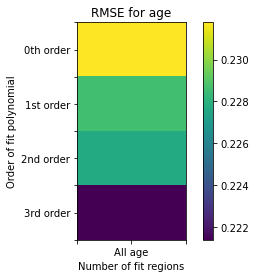

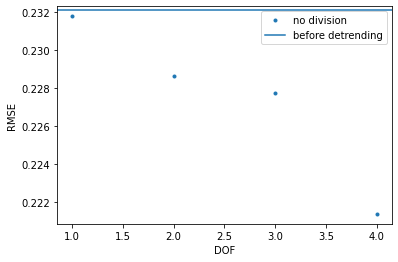

In [99]:
#choosing the right fit function and regions to fit for age

delta_age_sorted = delta_age[np.argsort(apf_age)]
apf_age_sprted = np.sort(apf_age)

# age
# age regions_list = [[slice(0,apf_Teff[-1])], [slice(0,), slice(4501,apf_Teff[-1])]]
age_regions_list = [[np.invert(np.isnan(apf_age))]]
red_chi_sq_arr = np.zeros([4,len(age_regions_list)])
RMSE_before_detrend = np.sqrt(np.mean(delta_age**2))
RMSE = np.zeros([4,len(age_regions_list)])
plt.figure(figsize = [15,16])
j = 1
for order in [0,1,2,3]:
    i = 0
    for region_set in age_regions_list:
        trend, poly,  RMSE, red_chi_sq_arr, i, j= fit_trend(apf_age, delta_age, order, region_set, i, j, 'age [Ga]', 1)
        plt.suptitle('age')
plt.tight_layout(pad = 6)  
       
plt.figure()
ax = plt.gca()
plt.imshow(red_chi_sq_arr, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All age'; #labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('Reduced Chi^2 for Age')
plt.colorbar()

plt.figure()
ax = plt.gca()
plt.imshow(RMSE, aspect = 0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'All age'; #labels[3] = 'Division at Teff = 4500K'
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = '0th order'; labels[3] = '1st order'; labels[5] = '2nd order'; labels[7] = '3rd order'
ax.set_yticklabels(labels)
plt.xlabel('Number of fit regions')
plt.ylabel('Order of fit polynomial')
plt.title('RMSE for age')
plt.colorbar()

plt.figure()
plt.plot(np.array([1,2,3,4]),RMSE[:,0], '.', label = 'no division')
plt.axhline(RMSE_before_detrend, label = 'before detrending')
#plt.plot(np.array([3,4,5,6]),RMSE[:,1], '.', label = 'Division at Teff = 4500K')
plt.xlabel('DOF'); plt.ylabel('RMSE'); plt.legend()

print('% decrease no detrend to constant offset: ' + str((RMSE_before_detrend - RMSE[0,0])*100/RMSE_before_detrend))
print('% decrease constant offset to linear: ' + str((RMSE[0,0]- RMSE[1,0])*100/RMSE[0,0]))
print('% decrease linear to quad: ' + str((RMSE[1,0] - RMSE[2,0])*100/RMSE[1,0]))
# so cutoff sohuld be like __% decrease -> constant becuase even though linear is the most significant decrease,
# looks like it's biased by outliers. 

#plt.xticklabel('')

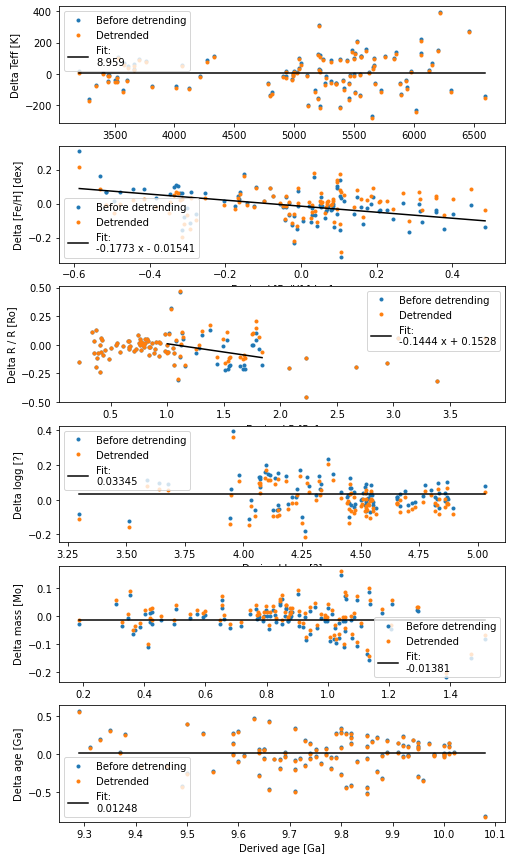

In [101]:
# perform the detrending

# Teff
plt.figure(figsize = [8,15])
plt.subplot(611)
plt.plot(apf_Teff, delta_Teff, '.', label = 'Before detrending')
plt.xlabel('Derived Teff [K]'); plt.ylabel('Delta Teff [K]')
region_set = [np.invert(np.isnan(apf_Teff))]
#plt.figure(figsize = [15,16])
order = 0
Teff_trend, Teff_poly, Teff_RMSE, Teff_red_chi_sq_arr, i, j= fit_trend(apf_Teff, delta_Teff, order, region_set, i=0, j=1, label = 'Teff [K]', make_plots = 0)
delta_Teff_detrended = delta_Teff - Teff_trend[0](apf_Teff)
apf_Teff_detrended = apf_Teff + Teff_trend[0](apf_Teff)
plt.plot(apf_Teff, yee_Teff - apf_Teff_detrended, '.', label = 'Detrended')
plt.plot(np.sort(apf_Teff[region_set[0]]), Teff_trend[0](np.sort(apf_Teff[region_set[0]])), label = 'Fit: ' + str(Teff_trend[0]), color = 'k')
plt.legend()

# [Fe/h]
#ax1 = plt.figure(2, figsize = [8,4])
plt.subplot(612)
plt.plot(apf_feh, delta_feh, '.', label = 'Before detrending')
plt.xlabel('Derived [Fe/H] [dex]'); plt.ylabel('Delta [Fe/H] [dex]')
region_set = [np.invert(np.isnan(apf_feh))]
order = 1
#plt.figure(figsize = [15,16])
feh_trend, feh_poly, feh_RMSE, feh_red_chi_sq_arr, i, j= fit_trend(apf_feh, delta_feh, order , region_set, i=0, j=1, label = '[Fe/H] [dex]', make_plots = 0)
delta_feh_detrended = delta_feh - feh_trend[0](apf_feh)
apf_feh_detrended = apf_feh + feh_trend[0](apf_feh)
plt.plot(apf_feh, yee_feh - apf_feh_detrended, '.', label = 'Detrended')
plt.plot(np.sort(apf_feh[region_set[0]]), feh_trend[0](np.sort(apf_feh[region_set[0]])), label = 'Fit: ' + str(feh_trend[0]), color = 'k')
plt.legend()

# Radius
#ax1 = plt.figure(3, figsize = [8,4])
plt.subplot(613)
plt.plot(apf_R, delta_R_R, '.', label = 'Before detrending')
plt.xlabel('Derived R [Ro]'); plt.ylabel('Delta R / R [Ro]')
region_set = [(1 <= apf_R) * (apf_R <= 2)]
region = region_set[0]
order = 1
#plt.figure(figsize = [15,16])
R_R_trend, R_R_poly, R_R_RMSE, R_R_red_chi_sq_arr, i, j= fit_trend(apf_R, delta_R_R, order , region_set, i=0, j=1, label = 'Radius [Ro]', make_plots = 0)
delta_R_R_detrended = np.copy(delta_R_R)
delta_R_R_detrended[region] = delta_R_R[region] - R_R_trend[0](apf_R[region])
apf_R_detrended = np.copy(apf_R )
apf_R_detrended[region] = apf_R[region]+ R_R_trend[0](apf_R[region])*apf_R[region]
plt.plot(apf_R, (yee_R - apf_R_detrended) / apf_R, '.', label = 'Detrended')
plt.plot(np.sort(apf_R[region_set[0]]), R_R_trend[0](np.sort(apf_R[region_set[0]])), label = 'Fit: ' + str(R_R_trend[0]), color = 'k')
plt.legend()

# Logg
#ax1 = plt.figure(2, figsize = [8,4])
plt.subplot(614)
plt.plot(apf_logg, delta_logg, '.', label = 'Before detrending')
plt.xlabel('Derived logg [?]'); plt.ylabel('Delta logg [?]')
region_set = [np.invert(np.isnan(apf_logg))]
order = 0
#plt.figure(figsize = [15,16])
logg_trend, logg_poly, logg_RMSE, logg_red_chi_sq_arr, i, j= fit_trend(apf_logg, delta_logg, order , region_set, i=0, j=1, label = 'logg [?]', make_plots = 0)
delta_logg_detrended = delta_logg - logg_trend[0](apf_logg)
apf_logg_detrended = apf_logg + logg_trend[0](apf_logg)
plt.plot(apf_logg, yee_logg - apf_logg_detrended, '.', label = 'Detrended')
plt.plot(np.sort(apf_logg[region_set[0]]), logg_trend[0](np.sort(apf_logg[region_set[0]])), label = 'Fit: ' + str(logg_trend[0]), color = 'k')
plt.legend()

# Mass
#ax1 = plt.figure(2, figsize = [8,4])
plt.subplot(615)
plt.plot(apf_mass, delta_mass, '.', label = 'Before detrending')
plt.xlabel('Derived mass [Mo]'); plt.ylabel('Delta mass [Mo]')
region_set = [np.invert(np.isnan(apf_mass))]
order = 0
#plt.figure(figsize = [15,16])
mass_trend, mass_poly, mass_RMSE, mass_red_chi_sq_arr, i, j= fit_trend(apf_mass, delta_mass, order , region_set, i=0, j=1, label = 'logg [?]', make_plots = 0)
delta_mass_detrended = delta_mass - mass_trend[0](apf_mass)
apf_mass_detrended = apf_mass + mass_trend[0](apf_mass)
plt.plot(apf_mass, yee_mass - apf_mass_detrended, '.', label = 'Detrended')
plt.plot(np.sort(apf_mass[region_set[0]]), mass_trend[0](np.sort(apf_mass[region_set[0]])), label = 'Fit: ' + str(mass_trend[0]), color = 'k')
plt.legend()

# Age
#ax1 = plt.figure(2, figsize = [8,4])
plt.subplot(616)
plt.plot(apf_age, delta_age, '.', label = 'Before detrending')
plt.xlabel('Derived age [Ga]'); plt.ylabel('Delta age [Ga]')
region_set = [np.invert(np.isnan(apf_age))]
order = 0
#plt.figure(figsize = [15,16])
age_trend, age_poly, age_RMSE, age_red_chi_sq_arr, i, j= fit_trend(apf_age, delta_age, order , region_set, i=0, j=1, label = 'logg [?]', make_plots = 0)
delta_age_detrended = delta_age - age_trend[0](apf_age)
apf_age_detrended = apf_age + age_trend[0](apf_age)
plt.plot(apf_age, yee_age - apf_age_detrended, '.', label = 'Detrended')
plt.plot(np.sort(apf_age[region_set[0]]), age_trend[0](np.sort(apf_age[region_set[0]])), label = 'Fit: ' + str(age_trend[0]), color = 'k')
plt.legend()

ValueError: operands could not be broadcast together with shapes (101,) (83,) 

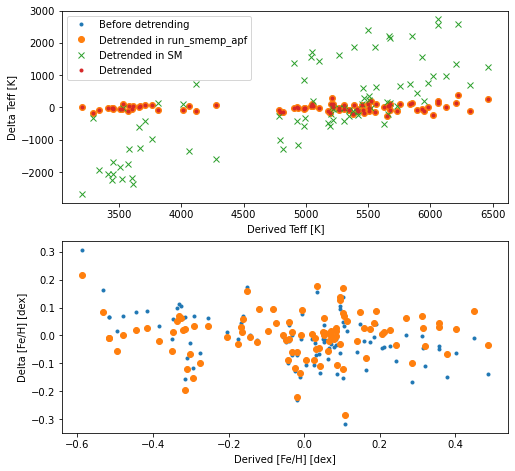

In [38]:
# check that the detrending in run_smemp_apf.ipynb is working

s=0;e=83 # to only look at a subset

# Teff
plt.figure(figsize = [8,12])
plt.subplot(311)
plt.plot(apf_Teff[s:e], delta_Teff[s:e], '.', label = 'Before detrending')
plt.xlabel('Derived Teff [K]'); plt.ylabel('Delta Teff [K]')
plt.plot(apf_Teff[s:e], yee_Teff[s:e] - apf_det_Teff[s:e], 'o', label = 'Detrended in run_smemp_apf')
plt.plot(apf_Teff[s:e], yee_Teff[s:e] - apf_det_SM_Teff[s:e], 'x', label = 'Detrended in SM')
plt.plot(apf_Teff[s:e], yee_Teff[s:e] - apf_Teff_detrended[s:e], '.', label = 'Detrended')
plt.legend()

# [Fe/H]
plt.subplot(312)
plt.plot(apf_feh, delta_feh, '.', label = 'Before detrending')
plt.xlabel('Derived [Fe/H] [dex]'); plt.ylabel('Delta [Fe/H] [dex]')
plt.plot(apf_feh, yee_feh - apf_det_feh, 'o', label = 'Detrended in run_smemp_apf')
plt.plot(apf_Teff, yee_feh - apf_det_SM_feh, 'x', label = 'Detrended in SM')
plt.plot(apf_feh, yee_feh - apf_feh_detrended, '.', label = 'Detrended')
plt.legend()

# Radius
plt.subplot(313)
plt.plot(apf_R, delta_R, '.', label = 'Before detrending')
plt.xlabel('Derived R [Ro]'); plt.ylabel('Delta  R [Ro]')
plt.plot(apf_R, yee_R - apf_det_R, 'o', label = 'Detrended in run_smemp_apf')
plt.plot(apf_R, yee_R - apf_det_SM_R, label = 'Detrended in SM')
plt.plot(apf_R, yee_R - apf_R_detrended, '.', label = 'Detrended')
plt.legend()

In [32]:
len(apf_det_SM_Teff)

83

In [111]:
# uncertianties to report for detrended quantities
apf_Teff_u = apf_det_sorted.iloc[:,2].to_numpy() 
apf_R_u = apf_det_sorted.iloc[:,4].to_numpy() 
apf_feh_u = apf_det_sorted.iloc[:,8].to_numpy() 

mean_Teff_u = np.mean(apf_Teff_u)
mean_R_u = np.mean(apf_R_u)
mean_feh_u = np.mean(apf_feh_u)

RMSE_Teff_det = np.sqrt(np.mean((yee_Teff - apf_Teff_detrended)**2))
print('Teff: ')
print('    ' + str(mean_Teff_u))
print('    ' + str(RMSE_Teff_det))
RMSE_feh_det = np.sqrt(np.mean((yee_feh - apf_feh_detrended)**2))
print('feh: ')
print('    ' + str(mean_feh_u))
print('    ' + str(RMSE_feh_det))
RMSE_R_det = np.sqrt(np.mean((yee_R - apf_R_detrended)**2))
print('R: ')
print('    ' + str(mean_R_u))
print('    ' + str(RMSE_R_det))

uncertainties = np.array([RMSE_Teff_det, RMSE_feh_det, RMSE_R_det]).reshape(1,3)
header = ['u_Teff_detrended [K]', 'u_[Fe/H]_detrended [dex]', 'u_R_detrended [Ro]']
df = pd.DataFrame(data=uncertainties, columns= header)
df.to_csv('/mnt_home/azuckerman/BL_APF_DAP/detrended_parameter_RMSE_values.csv') 

Teff: 
    113.97999999999998
    113.98029311670378
feh: 
    0.07999999999999999
    0.07993330514102645
R: 
    0.21000000000000005
    0.20998465778466505


In [121]:
# get the RMS between APF derived (pre-detrending) and library to use for uncertianties

apf_mass = apf_sorted.iloc[:,9].to_numpy() 
yee_mass = yee_sorted.iloc[:,9].to_numpy()
apf_logg = apf_sorted.iloc[:,5].to_numpy() 
yee_logg = yee_sorted.iloc[:,5].to_numpy()
apf_age = apf_sorted.iloc[:,11].to_numpy() 
yee_age = yee_sorted.iloc[:,11].to_numpy()

c0 = np.invert(np.isnan(yee_Teff))
c1 = yee_Teff < 4500
c2 = yee_Teff >= 4500
c3 = yee_R < 1.0
c4 = yee_R >= 1.0
cut = c4

RMSE_Teff = np.sqrt(np.mean((yee_Teff[cut] - apf_Teff_detrended[cut] )**2))
print('Teff: ')
print('    ' + str(RMSE_Teff))
RMSE_feh = np.sqrt(np.mean((yee_feh[cut] - apf_feh_detrended[cut])**2))
print('feh: ')
print('    ' + str(RMSE_feh))
RMSE_R_R = np.sqrt(np.mean(((yee_R[cut] - apf_R_detrended[cut])/apf_R_detrended[cut])**2))
print('R: ')
print('    ' + str(RMSE_R_R*100))


Teff: 
    144.84129570905415
feh: 
    0.08320434422214412
R: 
    17.01404782024065


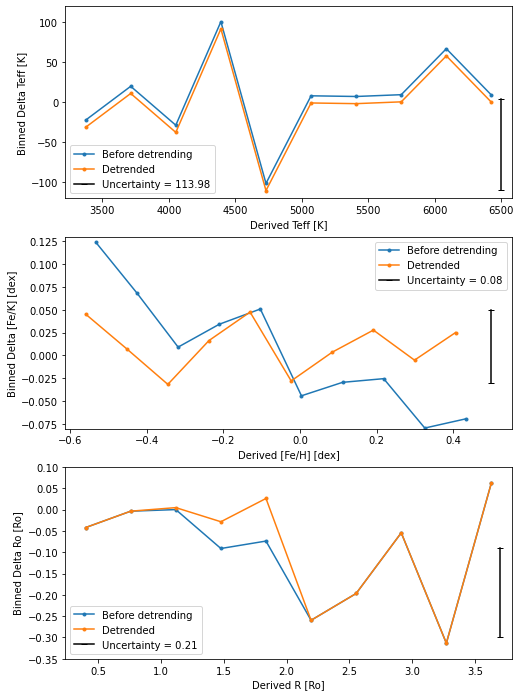

In [467]:
# plot the binned means
from scipy import stats
#import mpl_toolkits.axes_grid1.anchored_artists as anchored_artists
#from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Teff
ax = plt.figure(figsize = [8,12])
plt.subplot(311)
#ax1 = plt.figure(1, figsize = [8,4])
delta_Teff_means, bin_edges, bin_nums = stats.binned_statistic(apf_Teff, delta_Teff, statistic = 'mean', bins = 10)
bin_width = (bin_edges[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers, delta_Teff_means, '.-', label = 'Before detrending')
plt.xlabel('Derived Teff [K]'); plt.ylabel('Binned Delta Teff [K]')
delta_Teff_detrended_means, bin_edges, bin_nums = stats.binned_statistic(apf_Teff, delta_Teff_detrended, statistic = 'mean', bins = 10)
bin_width = (bin_edges[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers, delta_Teff_detrended_means, '.-', label = 'Detrended')
y_min = -120; y_max = 120
y_range = y_max - y_min
plt.axvline(6500, ymin = 10/y_range, ymax = (10 + RMSE_Teff_det)/y_range, label = 'Uncertainty = ' + str(np.round(RMSE_Teff_det,2)), color = 'k', marker = '_')
#bar = anchored_artists.AnchoredDrawingArea(20, 20, 0, 0, loc=1, frameon=False)
#ax.add_artist(bar)
plt.ylim([-120,120])
plt.legend()


# [Fe/H]
#ax1 = plt.figure(2, figsize = [8,4])
plt.subplot(312)
delta_feh_means, bin_edges, bin_nums = stats.binned_statistic(apf_feh, delta_feh, statistic = 'mean', bins = 10)
bin_width = (bin_edges[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers, delta_feh_means, '.-', label = 'Before detrending')
plt.xlabel('Derived [Fe/H] [dex]'); plt.ylabel('Binned Delta [Fe/K] [dex]')
delta_feh_detrended_means, bin_edges, bin_nums = stats.binned_statistic(apf_feh, delta_feh_detrended, statistic = 'mean', bins = 10)
bin_width = (bin_centers[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers, delta_feh_detrended_means, '.-', label = 'Detrended')
y_min = -0.08; y_max = 0.13
y_range = y_max - y_min
plt.axvline(0.5, ymin = 0.05/y_range , ymax = (0.05 + RMSE_feh_det)/y_range, label = 'Uncertainty = ' + str(np.round(RMSE_feh_det,2)), color = 'k', marker = '_')
plt.ylim([y_min,y_max])

plt.legend()


# Radius
#ax1 = plt.figure(3, figsize = [8,4])
plt.subplot(313)
delta_R_R_means, bin_edges, bin_nums = stats.binned_statistic(apf_R, delta_R_R, statistic = 'mean', bins = 10)
bin_width = (bin_edges[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers, delta_R_R_means, '.-', label = 'Before detrending')
plt.xlabel('Derived R [Ro]'); plt.ylabel('Binned Delta Ro [Ro]')
delta_R_R_detrended_means, bin_edges, bin_nums = stats.binned_statistic(apf_R, delta_R_R_detrended, statistic = 'mean', bins = 10)
bin_width = (bin_edges[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers, delta_R_R_detrended_means, '.-', label = 'Detrended')
y_min = -0.35; y_max = 0.10
y_range = y_max - y_min
plt.axvline(3.7, ymin = 0.05/y_range , ymax = (0.05 + RMSE_R_det)/y_range, label = 'Uncertainty = ' + str(np.round(RMSE_R_det,2)), color = 'k', marker = '_')
plt.ylim([y_min,y_max])
plt.legend()


In [102]:
# save the polynomial fits

np.savetxt('Teff_trend.csv', Teff_trend[0])
np.savetxt('feh_trend.csv', feh_trend[0])
np.savetxt('R_R_trend.csv', R_R_trend[0])
np.savetxt('logg_trend.csv', logg_trend[0])
np.savetxt('mass_trend.csv', mass_trend[0])
np.savetxt('age_trend.csv', age_trend[0])


#import csv

#filename = "detrending_functions.csv"
    
# writing to csv file 
#with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    #csvwriter = csv.writer(csvfile) 
        
    # writing the fields
    #csvwriter.writerow(['Property', 'Region(s)','Polynomial Coefficients']) 
    #Teff_row = ['Teff', 'all', Teff_poly[0]]
    #csvwriter.writerow(Teff_row) 
    #feh_row = ['[Fe/H]', 'all', feh_poly[0]]
    #csvwriter.writerow(feh_row) 
    #R_row = ['Radius','(1Ro <= R <= 2Ro)', R_R_poly[0]]
    #csvwriter.writerow(R_row) 
    #data = np.array([Teff_poly[0], feh_poly[0], R_R_poly[0]])
    #df = pd.DataFrame(data=data, index=["Teff (all)", "[Fe/H] (all)", "R (1Ro<=R<=2RO)"])#, columns=["column1", "column2"])    
    #df.to_csv(filename)

In [ ]:

# check the detrending
feh_params2, pcov = curve_fit(linear_func, apf_feh, delta_feh_detrended)
R_R_params2, pcov = curve_fit(linear_func, apf_R, delta_R_R_detrended)
Teff_params2, pcov = curve_fit(const_func, apf_Teff, delta_Teff_detrended)

# define the double trend functions
def delta_feh_double_trend(x):
    return feh_params2[0]*x + feh_params2[1]

def delta_R_R_double_trend(x):
    return R_R_params2[0]*x + R_R_params2[1]

def delta_Teff_double_trend(x):
    return Teff_params2[0]+ np.ones([len(x)])

plt.figure(figsize = [10,14])
plt.subplot(311)
#plt.plot(np.sort(apf_feh), linear_func(np.sort(apf_feh), *feh_params), label = 'fit: [Fe/H]_yee = ' + str(np.round(feh_params[0],2)) + '* [Fe/H]_apf + ' + str(np.round(feh_params[1],2)))
plt.plot(apf_feh, delta_feh_detrended,'.', label = 'Detrended Once')
plt.plot(apf_feh, delta_feh_double_trend(apf_feh), label = 'Trend: $\Delta$[Fe/H] = ' + str(np.round(feh_params2[0],3)) + '*APF_[Fe/H] + ' + str(np.round(feh_params2[1],3)))
delta_feh_double_detrended = delta_feh_detrended - delta_feh_double_trend(apf_feh)
plt.plot(apf_feh, delta_feh_double_detrended, '.', label = 'Double Detrended')
#plt.plot(np.linspace(-0.6,0.5,100),np.linspace(-0.6,0.5,100),'-.', color = 'k', label = '1:1' )
plt.xlabel('[Fe/H]_APF [dex]',fontsize = 12)
plt.ylabel('$\Delta$[Fe/H] [dex]',fontsize = 12)
plt.legend()

plt.subplot(312)
#plt.plot(np.sort(apf_feh), linear_func(np.sort(apf_feh), *feh_params), label = 'fit: [Fe/H]_yee = ' + str(np.round(feh_params[0],2)) + '* [Fe/H]_apf + ' + str(np.round(feh_params[1],2)))
plt.plot(apf_R, delta_R_R_detrended,'.', label = 'Detrended Once')
plt.plot(apf_R, delta_R_R_double_trend(apf_R), label = 'Trend: $\Delta$R_R = ' + str(np.round(R_R_params2[0],3)) + '*APF_R + ' + str(np.round(R_R_params2[1],3)))
delta_R_R_double_detrended = delta_R_R_detrended - delta_R_R_double_trend(apf_R)
plt.plot(apf_R, delta_R_R_double_detrended, '.', label = 'Double Detrended')
#plt.plot(np.linspace(-0.6,0.5,100),np.linspace(-0.6,0.5,100),'-.', color = 'k', label = '1:1' )
plt.xlabel('R_APF [Ro]',fontsize = 12)
plt.ylabel('$\Delta$R [Ro]',fontsize = 12)
plt.legend()

plt.subplot(313)
#plt.plot(np.sort(apf_feh), linear_func(np.sort(apf_feh), *feh_params), label = 'fit: [Fe/H]_yee = ' + str(np.round(feh_params[0],2)) + '* [Fe/H]_apf + ' + str(np.round(feh_params[1],2)))
plt.plot(apf_Teff, delta_Teff_detrended,'.', label = 'Detrended Once')
plt.plot(apf_Teff, delta_Teff_double_trend(apf_Teff), label = 'Trend: $\Delta$Teff = ' + str(np.round(R_R_params2[0],3)) + '* + APF_Teff')
delta_Teff_double_detrended = delta_Teff_detrended - delta_Teff_double_trend(apf_Teff)
plt.plot(apf_Teff, delta_Teff_double_detrended, '.', label = 'Double Detrended')
#plt.plot(np.linspace(-0.6,0.5,100),np.linspace(-0.6,0.5,100),'-.', color = 'k', label = '1:1' )
plt.xlabel('Teff_APF [K]',fontsize = 12)
plt.ylabel('$\Delta$Teff [K]',fontsize = 12)
plt.legend()

In [372]:
feh_poly
#feh_trend

[array([-0.17730377, -0.01540717])]

In [141]:
#  for checking which stars have the greatest differences
def check_differ():
    idxs = []
    for idx in range(len(yee_R)):
        if abs(apf_R[idx] - yee_R[idx])/yee_R[idx] > 1.0: # can change to any useful test
            idxs = idxs + [idx]
    diff = (apf_R - yee_R)/yee_R
    return idxs
check_differ()

[]

Text(0.5, 0, 'Hires derived [Fe/H] [dex]')

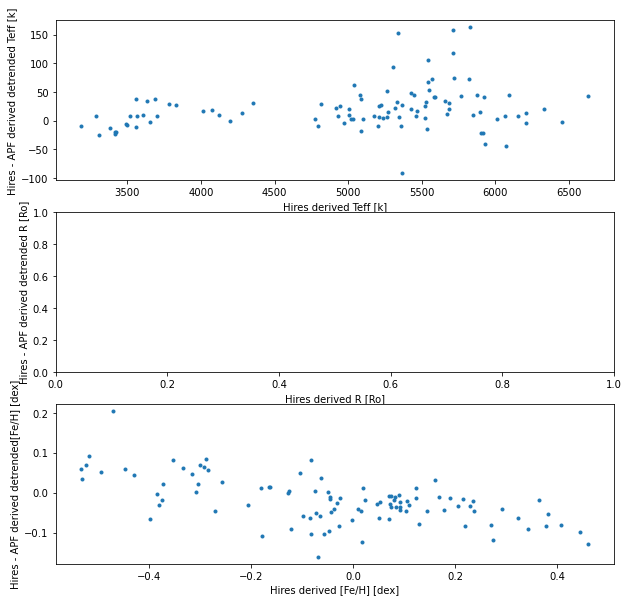

In [93]:
# compare the apf derived values and the Hires derived values

plt.figure(figsize = [10,10])
#plt.plot(hires_Teff, apf_Teff, '.')
plt.subplot(311)
plt.plot(hires_Teff, hires_Teff - apf_Teff_detrended, '.')
plt.ylabel('Hires - APF derived detrended Teff [k]')
plt.xlabel('Hires derived Teff [k]')

plt.subplot(312)
#plt.plot(hires_R, apf_R, '.')
#plt.plot(hires_R, hires_R - apf_R_detrended, '.')
plt.ylabel('Hires - APF derived detrended R [Ro]')
plt.xlabel('Hires derived R [Ro]')

plt.subplot(313)
#plt.plot(hires_Teff, apf_Teff, '.')
plt.plot(hires_feh, hires_feh - apf_feh_detrended, '.')
plt.ylabel('Hires - APF derived detrended[Fe/H] [dex]')
plt.xlabel('Hires derived [Fe/H] [dex]')

In [126]:
# calculate RMS for new results 
def calc_RMS(del_R, del_Teff, del_feh):
    diff = del_R
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('   rms_R = ' + str(np.round(rms_R_new,3)))

    diff =  del_Teff
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('   rms_Teff = ' + str(np.round(rms_T_new,3)))

    diff =  del_feh
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('   rms_feh = ' + str(np.round(rms_feh_new,3)))

def calc_mean_offset(del_R, del_Teff, del_feh):
    print('   mean_offset_R = ' + str(np.round(np.mean(del_R),3)))
    print('   mean_offset_Teff = ' + str(np.round(np.mean(del_Teff),3)))
    print('   mean_offset_feh = ' + str(np.round(np.mean(del_feh),3)))
    
          
print('Before detrending: ')
calc_RMS(delta_R_R, delta_Teff, delta_feh)
calc_mean_offset(delta_R_R, delta_Teff, delta_feh)
print('After detrending: ')
calc_RMS(delta_R_R_detrended, delta_Teff_detrended, delta_feh_detrended)
calc_mean_offset(delta_R_R_detrended, delta_Teff_detrended, delta_feh_detrended)

Before detrending: 
   rms_R = 0.128
   rms_Teff = 114.332
   rms_feh = 0.091
   mean_offset_R = -0.038
   mean_offset_Teff = 8.959
   mean_offset_feh = -0.011
After detrending: 
   rms_R = 0.118
   rms_Teff = 113.98
   rms_feh = 0.08
   mean_offset_R = -0.0
   mean_offset_Teff = -0.0
   mean_offset_feh = -0.0


In [ ]:
def calc_RMS_at_divisions():
    # To get at division in deltas at T ~ 4500K
    apf_Teff_1 = apf_Teff[yee_Teff < 4500]
    yee_Teff_1 = yee_Teff[yee_Teff < 4500]
    apf_Teff_2 = apf_Teff[yee_Teff >= 4500]
    yee_Teff_2 = yee_Teff[yee_Teff >= 4500]

    apf_R_1 = apf_R[yee_Teff < 4500]
    yee_R_1 = yee_R[yee_Teff < 4500]
    apf_R_2 = apf_R[yee_Teff >= 4500]
    yee_R_2 = yee_R[yee_Teff >= 4500]

    apf_feh_1 = apf_feh[yee_Teff < 4500]
    yee_feh_1 = yee_feh[yee_Teff < 4500]
    apf_feh_2 = apf_feh[yee_Teff >= 4500]
    yee_feh_2 = yee_feh[yee_Teff >= 4500]

    diff = (apf_R_1 - yee_R_1)/yee_R_1
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for T<4500 = ' + str(rms_R_new))

    diff = (apf_R_2 - yee_R_2)/yee_R_2
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for T>4500 = ' + str(rms_R_new))

    diff =  (apf_Teff_1 - yee_Teff_1)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for T<4500 = ' + str(rms_T_new))

    diff =  (apf_Teff_2 - yee_Teff_2)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for T>4500 = ' + str(rms_T_new))

    diff =  (apf_feh_1 - yee_feh_1)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for T<4500= ' + str(rms_feh_new))

    diff =  (apf_feh_2 - yee_feh_2)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for T>4500= ' + str(rms_feh_new))
    
    # To get at division in deltas at R ~ 1.0 Ro
    apf_Teff_1 = apf_Teff[yee_R < 1.0]
    yee_Teff_1 = yee_Teff[yee_R < 1.0]
    apf_Teff_2 = apf_Teff[yee_R > 1.0]
    yee_Teff_2 = yee_Teff[yee_R > 1.0]

    apf_R_1 = apf_R[yee_R < 1.0]
    yee_R_1 = yee_R[yee_R < 1.0]
    apf_R_2 = apf_R[yee_R > 1.0]
    yee_R_2 = yee_R[yee_R > 1.0]

    apf_feh_1 = apf_feh[yee_R < 1.0]
    yee_feh_1 = yee_feh[yee_R < 1.0]
    apf_feh_2 = apf_feh[yee_R > 1.0]
    yee_feh_2 = yee_feh[yee_R > 1.0]

    diff = (apf_R_1 - yee_R_1)/yee_R_1
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for R<1.0 = ' + str(rms_R_new))

    diff = (apf_R_2 - yee_R_2)/yee_R_2
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for R>1.0 = ' + str(rms_R_new))

    diff =  (apf_Teff_1 - yee_Teff_1)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for R<1.0 = ' + str(rms_T_new))

    diff =  (apf_Teff_2 - yee_Teff_2)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for R>1.0 = ' + str(rms_T_new))

    diff =  (apf_feh_1 - yee_feh_1)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for R<1.0 = ' + str(rms_feh_new))

    diff =  (apf_feh_2 - yee_feh_2)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for R>1.0 = ' + str(rms_feh_new))

calc_RMS_at_divisions()

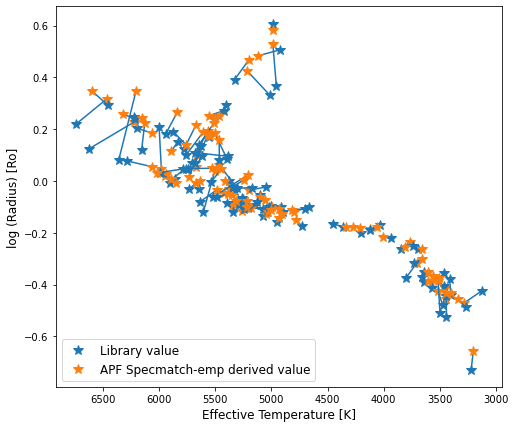

In [109]:
# visualize the difference betwenn library and derived values
all_yee_properties = pd.read_csv('yee_library_full.csv')
all_yee_Teff = all_yee_properties.iloc[:,1]
all_yee_R = all_yee_properties.iloc[:,3] 
plt.figure(figsize = (8,7));
for star in range(len(yee_Teff)):    
    if star == 1:
        labels = ['_nolegend_', 'Library value', 'APF Specmatch-emp derived value']
    else:
        labels = ['_nolegend_', '_nolegend_','_nolegend_']
    plt.plot([yee_Teff[star], apf_Teff[star]], [np.log10(yee_R[star]), np.log10(apf_R[star])],  c='C0',  label=labels[0])
    plt.plot(yee_Teff[star], np.log10(yee_R[star]),'*', markersize = 10, c = 'C0', label = labels[1]) # Just the ones we used
    plt.plot(apf_Teff[star], np.log10(apf_R[star]),'*', markersize = 10, c = 'C1', label = labels[2]) # just the ones we used
plt.gca().invert_xaxis()
plt.ylabel('log (Radius) [Ro]', fontsize = 12)
plt.xlabel('Effective Temperature [K]', fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig('Comparison_visual.png')

Text(0.5, 0, 'Effective Temperature [K]')

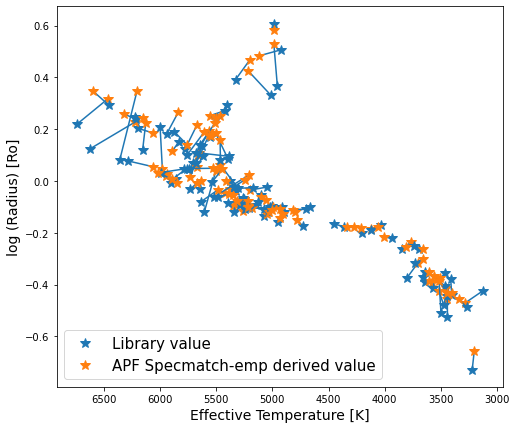

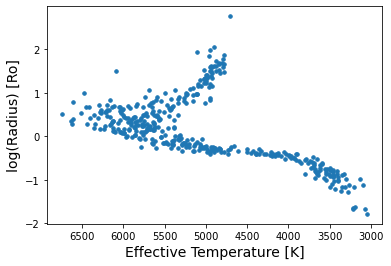

In [100]:
all_yee_properties = pd.read_csv('yee_library_full.csv')
all_yee_Teff = all_yee_properties.iloc[:,1]
all_yee_R = all_yee_properties.iloc[:,3] 
plt.figure(figsize = (8,7));
for star in range(len(yee_Teff)):    
    if star == 1:
        labels = ['_nolegend_', 'Library value', 'APF Specmatch-emp derived value']
    else:
        labels = ['_nolegend_', '_nolegend_','_nolegend_']
    plt.plot([yee_Teff[star], apf_Teff[star]], [np.log10(yee_R[star]), np.log10(apf_R[star])],  c='C0',  label=labels[0])
    plt.plot(yee_Teff[star], np.log10(yee_R[star]),'*', markersize = 10, c = 'C0', label = labels[1]) # Just the ones we used
    plt.plot(apf_Teff[star], np.log10(apf_R[star]),'*', markersize = 10, c = 'C1', label = labels[2]) # just the ones we used
plt.gca().invert_xaxis()
plt.ylabel('log (Radius) [Ro]', fontsize = 14)
plt.xlabel('Effective Temperature [K]', fontsize = 14)
plt.legend(fontsize = 15)

plt.figure();plt.plot(all_yee_Teff,np.log(all_yee_R),'.', markersize = 7, label = "library stars")
plt.gca().invert_xaxis()
plt.ylabel('log(Radius) [Ro]', fontsize = 14)
plt.xlabel('Effective Temperature [K]', fontsize = 14)
#plt.legend(fontsize = 15)

In [502]:
apf_sorted#.iloc[:,5]

,HIP_name,Teff,u_Teff,radius,u_radius,logg,u_logg,feh,u_feh,mass,u_mass,age,u_age,best_mean_chi_squared
0,HIP101345,5553.393,110.0,1.787,0.18,4.022,0.12,0.072,0.09,1.000,0.08,9.98,0.17,3.32
1,HIP10279,3527.969,70.0,0.417,0.10,4.836,0.12,-0.444,0.09,0.427,0.08,9.83,0.17,13.32
2,HIP103096,3659.117,70.0,0.547,0.10,4.731,0.12,0.107,0.09,0.548,0.08,9.80,0.17,3.95
3,HIP104202,4987.654,110.0,3.810,0.18,3.300,0.12,-0.047,0.09,1.037,0.08,9.95,0.17,2.75
4,HIP104214,4274.627,70.0,0.666,0.10,4.667,0.12,-0.254,0.09,0.653,0.08,9.60,0.17,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,HIP97051,4209.339,70.0,0.657,0.10,4.669,0.12,-0.176,0.09,0.648,0.08,9.61,0.17,4.65
79,HIP98036,5114.403,110.0,3.043,0.18,3.511,0.12,-0.043,0.09,1.008,0.08,9.97,0.17,3.20
80,HIP98505,5001.812,110.0,0.771,0.10,4.522,0.12,-0.007,0.09,0.799,0.08,9.80,0.17,3.67
81,HIP98767,5464.410,110.0,1.440,0.18,4.137,0.12,0.321,0.09,1.021,0.08,9.95,0.17,2.42


In [499]:
yee_sorted

,HIP_name,Teff [K],e_Teff [K],R* [Rsun],e_R* [Rsun],log(g) [cm/s2],e_log(g) [cm/s2],[Fe/H] [sun],e_[Fe/H] [sun],M* [Msun],...,e_logAge [yr],plx [mas],Vmag [mag],Notes,SCat,Gaia,2M,Simbad,_RA [deg],_DE [deg]
354,HIP101345,5421,118,1.867,0.083,3.91,0.07,0.06,0.10,1.03,...,0.15,41.3,5.7,"E,2",1,Gaia,2M,Simbad,308.09873,-9.85338
279,HIP10279,3638,62,0.443,0.017,4.79,0.05,-0.36,0.08,0.44,...,0.52,94.8,10.0,"D,1",1,Gaia,2M,Simbad,33.08745,3.57562
355,HIP103096,3692,22,0.547,0.007,4.72,0.01,-0.21,0.10,0.54,...,0.21,142.2,8.6,"E,1",1,Gaia,2M,Simbad,313.33245,62.15439
81,HIP104202,4983,60,4.050,0.590,3.22,0.05,-0.07,0.05,0.96,...,0.27,13.9,6.5,"A,1",1,Gaia,2M,Simbad,316.66601,3.80312
357,HIP104214,4361,17,0.661,0.005,4.63,0.02,-0.19,0.10,0.68,...,0.46,287.1,5.2,"E,2",0,Gaia,2M,Simbad,316.72480,38.74944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,HIP97051,4200,248,0.631,0.057,4.70,0.07,-0.19,0.10,0.62,...,0.52,38.5,10.0,"C,1",0,Gaia,2M,Simbad,295.85557,10.08951
350,HIP98036,4920,102,3.210,0.133,3.39,0.09,-0.14,0.10,0.92,...,0.17,73.0,3.7,"E,2",1,Gaia,2M,Simbad,298.82830,6.40676
73,HIP98505,5024,60,0.790,0.040,4.51,0.05,0.07,0.05,0.82,...,0.49,50.4,7.6,"A,1",1,Gaia,2M,Simbad,300.18214,22.71085
351,HIP98767,5461,75,1.200,0.033,4.26,0.04,0.21,0.10,0.94,...,0.09,62.4,5.7,"E,1",1,Gaia,2M,Simbad,300.90586,29.89680


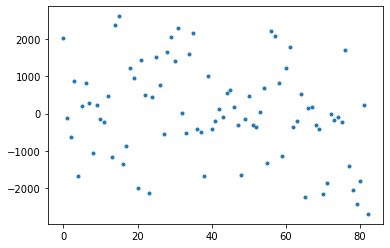

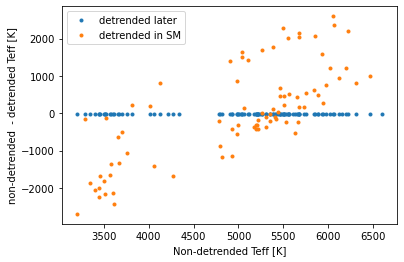

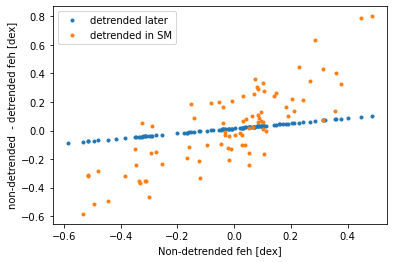

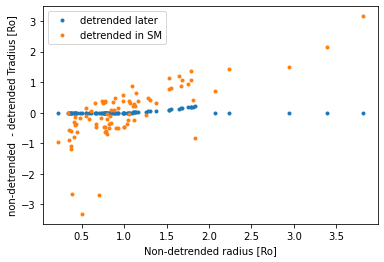

In [77]:
# quick check of detrending

apf_sorted = apf_sorted.reset_index(drop = True)
apf_det_SM_sorted = apf_det_SM_sorted.reset_index(drop = True)
apf_det_sorted = apf_det_sorted.reset_index(drop = True)

plt.plot(apf_det_sorted['Teff'] - apf_det_SM_sorted['Teff_detrended'],'.')
plt.figure()
plt.plot(apf_sorted['Teff'], apf_sorted['Teff'] - apf_det_sorted['Teff'],'.', label = 'detrended later' )
plt.plot(apf_sorted['Teff'], apf_sorted['Teff'] - apf_det_SM_sorted['Teff_detrended'],'.', label = 'detrended in SM' )
plt.xlabel('Non-detrended Teff [K]'); plt.ylabel('non-detrended  - detrended Teff [K]')
plt.legend()


#plt.plot(apf_det_sorted['feh'] - apf_det_SM_sorted['feh_detrended'],'.')
plt.figure()
plt.plot(apf_sorted['feh'], apf_sorted['feh'] - apf_det_sorted['feh'],'.', label = 'detrended later' )
plt.plot(apf_sorted['feh'], apf_sorted['feh'] - apf_det_SM_sorted['feh_detrended'],'.', label = 'detrended in SM' )
plt.xlabel('Non-detrended feh [dex]'); plt.ylabel('non-detrended  - detrended feh [dex]')
plt.legend()


#plt.plot(apf_det_sorted['radius'] - apf_det_SM_sorted['radius_detrended'],'.')
plt.figure()
plt.plot(apf_sorted['radius'].iloc[s:e], apf_sorted['radius'].iloc[s:e] - apf_det_sorted['radius'].iloc[s:e],'.', label = 'detrended later' )
plt.plot(apf_sorted['radius'].iloc[s:e], apf_sorted['radius'].iloc[s:e] - apf_det_SM_sorted['radius_detrended'].iloc[s:e],'.', label = 'detrended in SM' )
plt.xlabel('Non-detrended radius [Ro]'); plt.ylabel('non-detrended  - detrended Tradius [Ro]')
plt.legend()
#plt.plot(apf_det_SM_sorted['Teff_detrended'],'.')

In [60]:
len(apf_sorted[s:e])

83

In [72]:
apf_sorted['radius'].iloc[s:e]

0     1.787
1     0.417
2     0.547
3     3.810
4     0.666
      ...  
78    0.369
79    0.445
80    0.421
81    1.750
82    0.221
Name: radius, Length: 83, dtype: float64

In [75]:
apf_det_sorted['radius'].iloc[s:e].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             13,  90,  14,  15,  16,  98,  86,  17,  96,  18,  19,  20,  21,
             22,  23,  24,  25,  26,  27,  28,  29,  84,  30,  31,  32,  33,
             85,  34,  35,  36,  37,  38, 100,  39,  83,  40,  41,  42,  43,
             44,  45,  46,  47,  87,  99,  88,  92,  48,  49,  50,  51,  52,
             93,  97,  53,  54,  55,  56,  94,  57,  58,  59,  60,  61,  91,
             62,  63,  64,  65,  66],
           dtype='int64')

In [ ]:
plt.plot(apf_sorted['radius'][s:e], apf_sorted['radius'].iloc[s:e] - apf_det_sorted['radius'].iloc[s:e],'.', label = 'detrended later' )
